Reference: [source notebook](https://github.com/joydeepmedhi/Anchor-Boxes-with-KMeans/blob/master/EDA%20of%20bbox.ipynb)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from collections import Counter
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns
import copy
import torch
import os
import xmltodict
from dotmap import DotMap
import seaborn as sns

In [2]:
sys.path.append("..")
from src.data.data_loader import CreateDataLoader

In [3]:
SPLIT = "train"
MIN_SIZE=2000
MAX_SIZE=2500

In [4]:
dataset_opt = DotMap({
    "dataset": "AI4EU",
    "annotators": [0,4,5,6],
    "annotator_draw": 0,
    "split_path": '../data/splits/split3.json',
    "labels_dir": '../data/all_labels',
    "images_dir": '../data/complete_dataset',
    "phase": SPLIT,
    "nThreads": 0,
    "batch_size": 2,
    "step_batch_size":1
})

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')

GPU


In [6]:
data_holder = CreateDataLoader(dataset_opt)

CustomDatasetDataLoader
dataset [AI4EU] was created


In [7]:
from src.utils.transforms import resize as resize_data

In [8]:
from notebooks.utils import get_item


In [9]:
all_boxes = None
for i, image_id in enumerate(data_holder.dataset.ids):
    image, target = get_item(data_holder, image_id, resize=True, min_size=MIN_SIZE, max_size=MAX_SIZE)
    if all_boxes is not None:
        all_boxes = np.concatenate([all_boxes, target["boxes"].detach().cpu().numpy()])
    else:
        all_boxes = target["boxes"].detach().cpu().numpy()
    if not i % 50:
        print(f"{len(data_holder) - i} left")

171 left
121 left
71 left
21 left


In [10]:
data = pd.DataFrame(all_boxes, columns = ['xmin', 'ymin', 'xmax', 'ymax'])
data['w'] = data['xmax'] - data['xmin'] + 1
data['h'] = data['ymax'] - data['ymin'] + 1
data = data[(data["w"] > 2) & (data["h"] > 2)]

In [11]:
data["ar"] = data["w"]/data["h"]
data["area"] = data["w"]*data["h"]

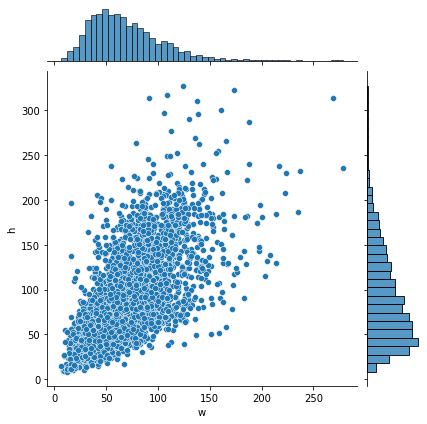

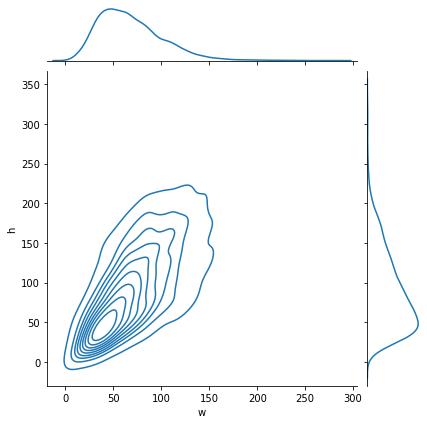

In [12]:
#Joint Plot of b_w and b_h
sns.jointplot(x="w", y="h", data=data)
sns.jointplot(x="w", y="h", data=data, kind='kde')

In [13]:
data.describe()

,xmin,ymin,xmax,ymax,w,h,ar,area
count,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000
mean,1178.029053,968.247620,1245.068848,1056.173584,68.039719,88.926018,0.878217,7203.893066
std,676.827209,231.215057,677.017639,234.764587,33.370167,50.486401,0.387655,7098.843750
min,0.600962,0.765931,11.488971,170.802689,6.580353,8.659302,0.078916,71.859375
25%,628.939102,821.325653,696.924622,905.877991,43.126221,48.500000,0.606917,2156.448792
50%,1175.649902,944.035248,1242.869568,1031.479797,62.383911,78.500000,0.794364,4944.406494
75%,1706.194244,1082.440247,1770.641876,1180.300293,86.565430,121.251221,1.076698,9920.950928
max,2485.000000,1838.125000,2500.000000,1950.000000,278.157715,327.286774,4.043647,84355.304688


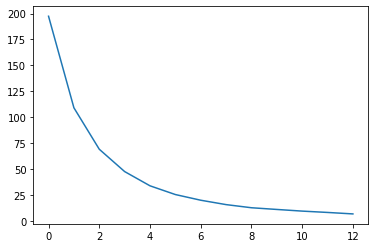

In [14]:
X = data.loc[:,"ar"].values
X = X.reshape(-1,1)
loss = []
from sklearn.cluster import KMeans
for i in range(2,15):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [15]:
n_clusters_ar=5

In [16]:
from sklearn.cluster import KMeans
K = KMeans(n_clusters_ar, random_state=1)
labels = K.fit(X)
print("Aspect Ratios:")
print(labels.cluster_centers_)

Aspect Ratios:
[[2.2284126 ]
 [0.787248  ]
 [1.1172757 ]
 [0.51083803]
 [1.5238786 ]]


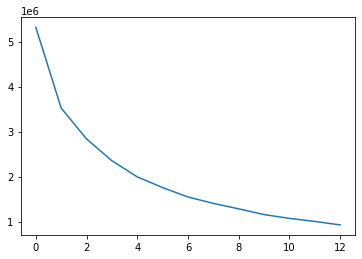

In [17]:
X = data.loc[:,["w","h"]].values
loss = []
from sklearn.cluster import KMeans
for i in range(2,15):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [18]:
n_clusters_wh = 5

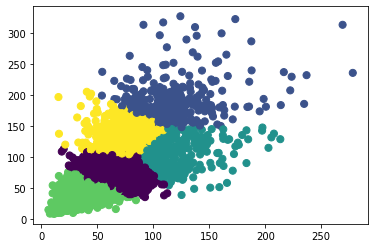

In [19]:
X = data[["w","h"]].values
h_idx = 1
w_idx = 0

from sklearn.cluster import KMeans
K = KMeans(n_clusters_wh, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, w_idx], X[:, h_idx], c=labels.labels_,
            s=50, cmap='viridis');

In [20]:
labels.cluster_centers_

array([[ 64.271515,  77.341324],
       [118.201294, 188.56577 ],
       [118.899124, 106.13513 ],
       [ 38.30014 ,  40.25302 ],
       [ 74.37644 , 133.98145 ]], dtype=float32)

In [21]:
out = labels.cluster_centers_

# torchvision's AR definition is AR=height/width
ar = out[:,h_idx]/out[:,w_idx]
scale = out[:,w_idx]*np.sqrt(ar)

print ("Aspect Ratios: ")
print (ar)

print ("Scales: ")
print (scale)

Aspect Ratios: 
[1.203353  1.5952935 0.8926486 1.0509889 1.8013963]
Scales: 
[ 70.50421  149.29405  112.33598   39.264442  99.825165]


In [22]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters, nearest_clusters

In [23]:
n_clusters_iou=5

In [24]:
iou_based_clusters, nearest_clusters = kmeans(translate_boxes(data[["xmin","ymin","xmax","ymax"]].values), n_clusters_iou)
iou_based_clusters

array([[ 45.190002,  49.60315 ],
       [ 29.871338,  29.141846],
       [ 78.75    , 124.007935],
       [116.875   , 164.375   ],
       [ 64.338196,  78.75    ]], dtype=float32)

In [25]:
from sklearn import linear_model
mod=linear_model.LinearRegression()
x=X[:,w_idx].reshape(-1,1)
mod.fit(x,y=X[:,h_idx])
y_hat=mod.predict(x)

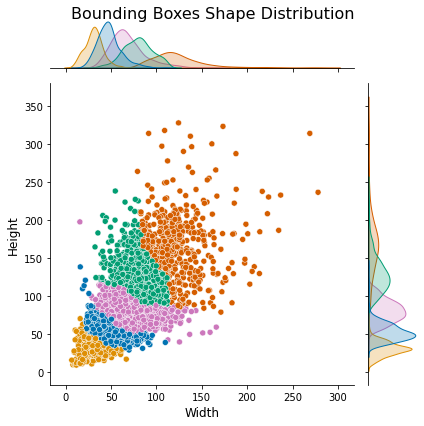

In [26]:
X = data[["w","h"]].values

from sklearn.cluster import KMeans
K = KMeans(n_clusters_iou, random_state=0)
labels = K.fit(X)
#fig, ax = plt.subplots(figsize=(7,7))
h=sns.jointplot(x=X[:, w_idx], y=X[:, h_idx], hue=nearest_clusters, palette='colorblind', legend=False)
#            s=50), cmap='viridis')
#plt.plot(X[:,w_idx], y_hat)
h.set_axis_labels('Width', 'Height', fontsize=12)
#ax.set_ylabel('Height')
#ax.set_xlabel('Width')
#ax.set_aspect(1)
h.fig.suptitle("Bounding Boxes Shape Distribution", fontsize=16)
h.fig.tight_layout()
h.fig.subplots_adjust(top=0.95)
plt.savefig('./figures/anchors_analysis.png',bbox_inches='tight')
plt.show()

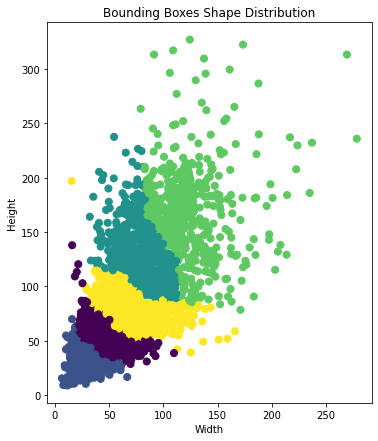

In [27]:
X = data[["w","h"]].values

from sklearn.cluster import KMeans
K = KMeans(n_clusters_iou, random_state=0)
labels = K.fit(X)
fig, ax = plt.subplots(figsize=(7,7))
#sns.jointplot(X[:, w_idx], X[:, h_idx], hue=nearest_clusters, ax=ax)
#            s=50), cmap='viridis')
plt.scatter(X[:, w_idx], X[:, h_idx], c=nearest_clusters,
            s=50, cmap='viridis')
#plt.plot(X[:,w_idx], y_hat)
plt.ylabel('Height')
plt.xlabel('Width')
ax.set_aspect(1)
plt.title('Bounding Boxes Shape Distribution')
plt.savefig('./figures/anchors_analysis.png',bbox_inches='tight')
plt.show()

In [28]:
out = iou_based_clusters
out = np.array(sorted(out, key= lambda shape: shape[0]))
# torchvision's AR definition is AR=height/width
aspect_ratios = out[:,h_idx]/out[:,w_idx]

# torchvision implementation of building anchor boxes from scales and aspect ratios work by getting
# boxes with the same area as the squared box with width/height "scale".
scales = np.sqrt(out[:,h_idx]*out[:,w_idx]) # Squared box width/heihgt with same area as the original box

print ("Aspect Ratios: ")
print (aspect_ratios)

print ("Scales: ")
print (scales)

Aspect Ratios: 
[0.97557884 1.0976576  1.2240007  1.5747039  1.4064171 ]
Scales: 
[ 29.504337  47.345184  71.18028   98.821175 138.60493 ]


In [29]:
pd.DataFrame(sorted(zip(scales, aspect_ratios)))

,0,1
0,29.504337,0.975579
1,47.345184,1.097658
2,71.180283,1.224001
3,98.821175,1.574704
4,138.604935,1.406417
